In [2]:
import torch
import torch.nn as nn
import torch.fft as fft


In [3]:
''' 
Using Nishizaki et al. (2019)'s suggestions for ResNet2

'''

" \nUsing Nishizaki et al. (2019)'s suggestions for ResNet2\n\n"

In [4]:
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding =1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size = 3, stride = 1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels or True:  # True for stride=2
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):

        shortcut = self.shortcut(x)
        #print("passed shortcut")

        output2 = self.bn1(x)
        #print("passed bn1")
        
        output2 = self.relu(output2)
        #print("passed relu 1")

        output2 = self.conv1(output2)
        #print("passed conv1")

        output2 = self.bn2(output2)
        #print("passed bn2")

        output2 = self.relu(output2)
        #print("passed relu 2")

        output2 = self.conv2(output2)
        #print("passed conv2")

        output = output2 + shortcut
        return output

In [59]:
x = torch.randn(1,1, 64, 64)
block = DBlock(1, 1)
output = block(x)
print(output.size())

torch.Size([1, 1, 32, 32])


In [5]:
class UBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UBlock, self).__init__()
        self.tconv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding = 1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.tconv2 = nn.Conv2d
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        output1 = self.tconv1(x)
        #print("passed tconv1")

        output2 = self.bn1(x)
        #print("passed bn1")

        output2 = self.relu(output2)
        #print("passed relu")

        output2 = self.tconv1(output2)
        #print("passed tconv")

        output2 = self.bn2(output2)
        #print("passed bn2")

        output2 = self.relu(output2)
        #print("passed relu 2")

        output2 = self.conv2(output2)
        #print("passed conv2")

        output = output1 + output2
        return output


In [6]:
x = torch.randn(1,1, 64, 64)
block = UBlock(1, 1)
output = block(x)
print(output.size())

torch.Size([1, 1, 128, 128])


In [7]:
class SBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)#, padding=1)
    def forward(self, x):
        output = self.conv1(x)
        return output

In [8]:
x = torch.rand(1,1, 64, 64)
bloc = SBlock(1,1)
output = bloc(x)
print(output.size())

torch.Size([1, 1, 64, 64])


In [9]:
class ResNet2(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super(ResNet2, self).__init__()
        self.s1 = SBlock(in_channels=in_channels, out_channels=out_channels)
        self.s2 = SBlock(in_channels=out_channels, out_channels=out_channels)
        self.d1 = DBlock(in_channels=in_channels,out_channels=out_channels)
        self.d2 = DBlock(in_channels=out_channels, out_channels=out_channels)
        self.u1 = UBlock(in_channels=out_channels, out_channels=out_channels)
        self.u2 = UBlock(in_channels=out_channels, out_channels=out_channels)
    def forward(self, x):
        #print("starting")

        output_inside = self.d1(x)
            
        output_du = self.d2(output_inside)
        output_du = self.u1(output_du)
        
        #print(output_du.size(3))

        output_s1 = self.s1(x)
       
        output_s2 = self.s2(output_inside)
        #output_du = nn.functional.interpolate(output_du, size=(output_s2.size(3), output_s2.size(3)), mode="bilinear", align_corners=False)


        #print("du type", output_du.size())
        #print("s2 type", output_s2.size())

        output_du = output_du + output_s2
        
        output_du = self.u2(output_du)

       # output_s1 = nn.functional.interpolate(output_s1, size=(output_du.size(3), output_du.size(3)), mode="bilinear", align_corners=False)

        output = output_s1 + output_du
        #print("passed")
        return output



In [10]:
''' 
Training ResNet2
Requires training set.
'''

' \nTraining ResNet2\nRequires training set.\n'

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
import time
from tqdm import tqdm

In [12]:
def gaussian_kernel(size):
    gaussian_kernel = Gaussian2DKernel(size, size, x_size=9*size)
    return gaussian_kernel

def create_DM(n, dist, size, bounds):
    mid = int(dist/2)
    Z = np.zeros((n, n))
    actuator_number = 0

    for i in range(mid, n, dist):
        for j in range(mid, n, dist):
            Z[i, j] = 2 * np.random.rand() - 1 #change this value with 0 to produce a flat DM
            actuator_number = actuator_number + 1
            # creates Dirac comb with random points
    grid_convolved = convolve(Z, gaussian_kernel(size))
    #print("Number of actuators: ", actuator_number)

    # scales Gaussian grid to appropriate phase bounds

    min_val = -bounds # minimum phase value
    max_val = bounds # maximum phase value

    grid_convolved_min = grid_convolved.min() # finds minimum and maximum of grid from above
    grid_convolved_max = grid_convolved.max()

    #scaled_dm = grid_convolved # uncomment this, and comment next line if dealing with flat DM.

    scaled_dm = (grid_convolved - grid_convolved_min) * (max_val - min_val)/(grid_convolved_max - grid_convolved_min) + min_val
    # scales the grid to the phase bounds clarified above
    
    return scaled_dm

Text(0.5, 1.0, 'Deformable mirror')

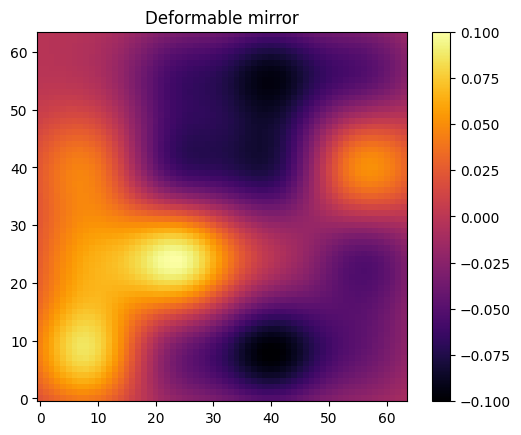

In [16]:
num_pix = 64
dist = 16
size = 7
bounds = 0.1
wvl = 200e-9

deform_mirror = create_DM(num_pix, dist, size, bounds)

plt.imshow(deform_mirror, origin="lower", cmap="inferno")
plt.colorbar()
plt.title("Deformable mirror")

Text(0.5, 1.0, 'Intensity of light reflected off of DM  in far-field')

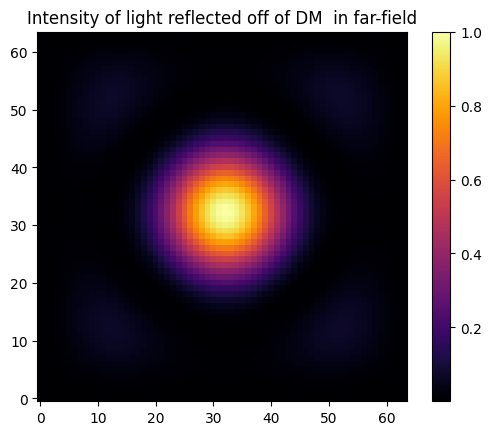

In [17]:
from scipy.ndimage import zoom

u2 = Fourf_optical_system_simulation_v1.u2

origPix = len(u2[0])
factor = num_pix/origPix
u2 = zoom(u2, factor, order=3)
#plt.imshow(fftshift(np.abs(u2))**2, cmap="plasma")

reflected_PSF = fftshift(np.abs(fft2(u2*np.exp(1j*deform_mirror)))**2)
reflected_PSF = reflected_PSF/(np.max(reflected_PSF))
plt.imshow(reflected_PSF, cmap = "inferno", origin="lower")
plt.colorbar()
plt.title("Intensity of light reflected off of DM  in far-field")
#plt.clim(0, 2e27)

In [18]:
def generate_test_set(num_vals, num_pix, dist, size, bounds):
    dataArray = np.zeros((num_vals, num_pix, num_pix), dtype=np.float32)
    controlMatrix = np.zeros((num_vals, num_pix, num_pix), dtype=np.float32)
    reflectedPSF = np.zeros((num_vals, num_pix, num_pix), dtype=np.float32)

    for x in tqdm(range(num_vals)):
        dataArray[x] = create_DM(num_pix, dist, size, bounds)
        controlMatrix[x] = -1*dataArray[x]
        reflectedPSF[x] = fftshift(np.abs(fft2(u2*np.exp(1j*dataArray[x])))**2)
    
    reflectedPSF = reflectedPSF/np.max(reflectedPSF)
    
    dm_tensor = torch.from_numpy(dataArray)
    control_tensor = torch.from_numpy(controlMatrix)
    psf_tensor = torch.from_numpy(reflectedPSF)

    return dm_tensor, control_tensor, psf_tensor

In [17]:
num_pix = 64
dist = 16
size = 7
bounds = 0.1
num_vals = 100000
dm_tensor, control_tensor, psf_tensor = generate_test_set(num_vals, num_pix, dist, size, bounds)
print("Set generated")

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [32:17<00:00, 51.61it/s]


Set generated


In [19]:
from torch.utils.data import TensorDataset, DataLoader
#psf_tensor = torch.from_numpy(psf_tensor)
train_set = TensorDataset(psf_tensor, control_tensor)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32)

for images, labels in train_loader:
    print(images.shape)
    break

rand_psf, rand_dm = train_set[2000]
plt.imshow(fftshift(rand_psf.numpy()))
plt.imshow(rand_dm.numpy())


NameError: name 'psf_tensor' is not defined

In [67]:
'''
Setting up loss function
'''
criterion = nn.MSELoss()

model = ResNet2()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)


In [71]:
'''
Training loop
'''
num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    lossArray = np.zeros(num_epochs)

    for batch_psf, batch_control in train_loader:
        batch_psf = batch_psf.unsqueeze(1)
        batch_control = batch_control.unsqueeze(1)
        #print(batch_psf.size())
        #print("NaNs in input:", torch.isnan(batch_control).any())  # Should be False
        #print(f"Input stats: min={batch_psf.min().item()}, max={batch_psf.max().item()}")
        preds = model(batch_psf)
        #print("preds stats:", preds.min().item(), preds.max().item(), preds.mean().item())
        #print("target stats:", batch_control.min().item(), batch_control.max().item(), batch_control.mean().item())

        loss = criterion(preds, batch_control)
        #print("loss value:", loss.item())

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.6f}")
    lossArray[epoch] = loss.item()

  5%|▌         | 1/20 [04:34<1:27:04, 274.97s/it]

Epoch 1/20, Loss = 0.002251


 10%|█         | 2/20 [12:11<1:54:31, 381.73s/it]

Epoch 2/20, Loss = 0.002212


 15%|█▌        | 3/20 [21:32<2:11:23, 463.71s/it]

Epoch 3/20, Loss = 0.002212


 20%|██        | 4/20 [32:14<2:22:23, 533.96s/it]

Epoch 4/20, Loss = 0.002212


 25%|██▌       | 5/20 [42:57<2:23:19, 573.27s/it]

Epoch 5/20, Loss = 0.002212


 30%|███       | 6/20 [53:34<2:18:48, 594.87s/it]

Epoch 6/20, Loss = 0.002212


 35%|███▌      | 7/20 [1:04:09<2:11:46, 608.23s/it]

Epoch 7/20, Loss = 0.002212


 40%|████      | 8/20 [1:14:40<2:03:05, 615.49s/it]

Epoch 8/20, Loss = 0.002212


 45%|████▌     | 9/20 [1:25:16<1:53:58, 621.68s/it]

Epoch 9/20, Loss = 0.002212


 50%|█████     | 10/20 [1:34:30<1:40:09, 600.92s/it]

Epoch 10/20, Loss = 0.002212


 55%|█████▌    | 11/20 [1:43:18<1:26:47, 578.56s/it]

Epoch 11/20, Loss = 0.002212


 60%|██████    | 12/20 [1:52:12<1:15:20, 565.03s/it]

Epoch 12/20, Loss = 0.002212


 65%|██████▌   | 13/20 [2:01:07<1:04:51, 555.94s/it]

Epoch 13/20, Loss = 0.002212


 70%|███████   | 14/20 [2:10:04<55:00, 550.16s/it]  

Epoch 14/20, Loss = 0.002212


 75%|███████▌  | 15/20 [2:18:55<45:22, 544.55s/it]

Epoch 15/20, Loss = 0.002212


 80%|████████  | 16/20 [2:27:46<36:01, 540.36s/it]

Epoch 16/20, Loss = 0.002212


 85%|████████▌ | 17/20 [2:36:45<27:00, 540.01s/it]

Epoch 17/20, Loss = 0.002212


 90%|█████████ | 18/20 [2:45:24<17:46, 533.47s/it]

Epoch 18/20, Loss = 0.002212


 95%|█████████▌| 19/20 [2:54:35<08:58, 538.98s/it]

Epoch 19/20, Loss = 0.002212


100%|██████████| 20/20 [3:03:40<00:00, 551.03s/it]

Epoch 20/20, Loss = 0.002212


In [72]:
torch.save(model.state_dict(), "resnet2_weights.pth")

In [20]:
# Recreate model (must match training architecture)
model_old = ResNet2(in_channels=1, out_channels=1)

# Load saved weights
model_old.load_state_dict(torch.load("resnet2_weights.pth"))


<All keys matched successfully>

torch.Size([1, 1, 64, 64])
MSE(preds vs PSF): tensor(0.0401)
MSE(preds vs DM): tensor(0.0023, dtype=torch.float64)


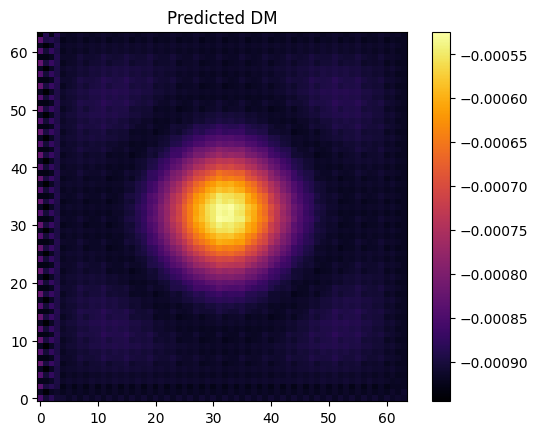

In [24]:
testDM = create_DM(num_pix, dist, size, bounds)
testPSF = fftshift(np.abs(fft2(u2*np.exp(1j*testDM)))**2)
testPSF = (testPSF)/(np.max((testPSF)))
#plt.imshow(testPSF)
testPSF = torch.from_numpy(testPSF).float()
testPSF = testPSF.unsqueeze(0)
testPSF = testPSF.unsqueeze(1)
print(testPSF.size())

with torch.no_grad():
    predicted_Cont = model_old(testPSF)
    
    print("MSE(preds vs PSF):", torch.nn.functional.mse_loss(predicted_Cont, testPSF))
    print("MSE(preds vs DM):", torch.nn.functional.mse_loss(predicted_Cont, torch.from_numpy(testDM).unsqueeze(0).unsqueeze(1)))

pred_image_c = predicted_Cont[0, 0,:,:].numpy()
#pred_image_c = pred_image_c.permute(1,2,0).numpy()
plt.imshow(pred_image_c, origin="lower", cmap="inferno")
plt.title("Predicted DM")
plt.colorbar()

Text(0.5, 1.0, 'Actual DM')

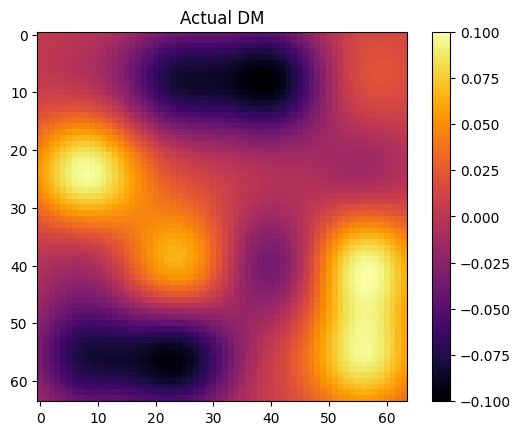

In [25]:
#plt.imshow(fftshift(np.abs(fft2(u2*np.exp(1j*testDM)))**2))
plt.imshow(-1*testDM, cmap="inferno")
plt.colorbar()
plt.title("Actual DM")

In [ ]:
'''
Validation set
'''

d_length: 20.480000000000018
d_lower: 245.76
d_upper: 266.24
d_avg: 256.0
10.24
9.765625e-07


[NbConvertApp] Converting notebook Fourf_optical_system_simulation_v1.ipynb to script
[NbConvertApp] Writing 9532 bytes to Fourf_optical_system_simulation_v1.py


d_length: 20.480000000000018
d_lower: 245.76
d_upper: 266.24
d_avg: 256.0
10.24
9.765625e-07


[NbConvertApp] Converting notebook Fourf_optical_system_simulation_v1.ipynb to script
[NbConvertApp] Writing 9532 bytes to Fourf_optical_system_simulation_v1.py


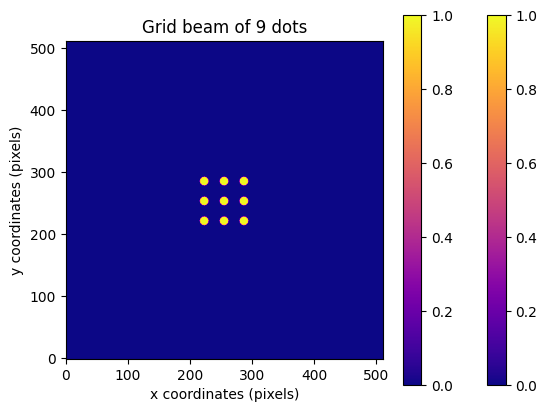

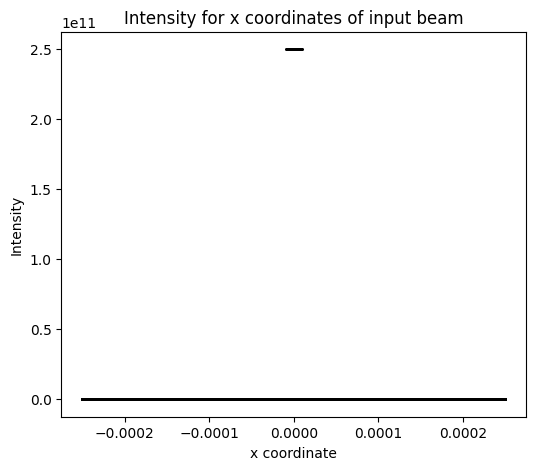

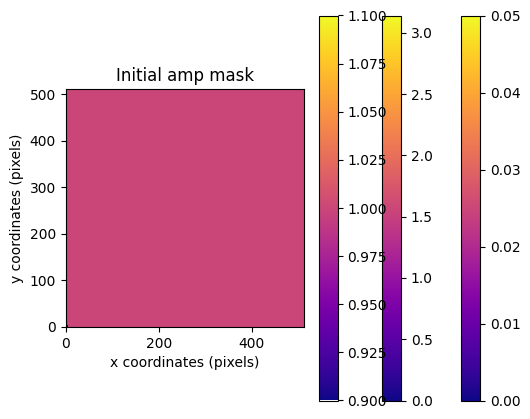

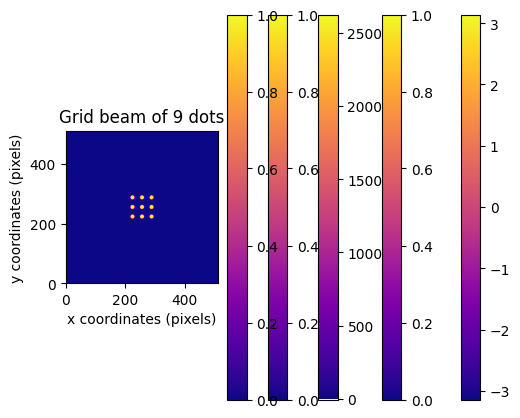

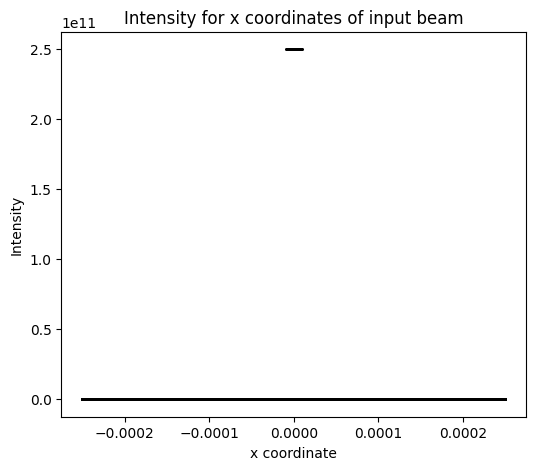

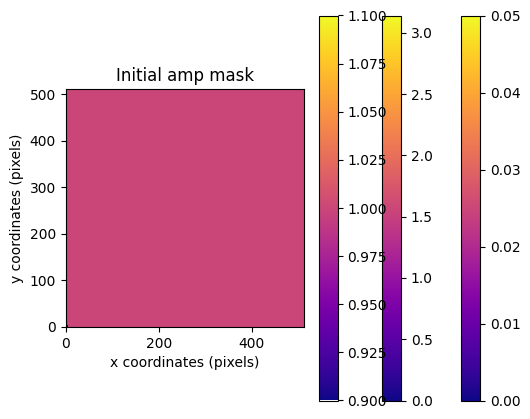

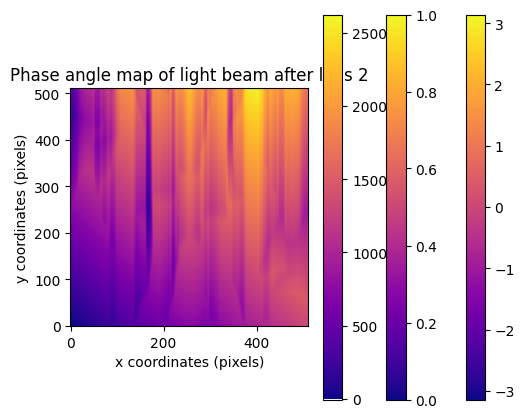

In [15]:
import importlib
import Fourf_optical_system_simulation_v1
importlib.reload(Fourf_optical_system_simulation_v1)
u2 = Fourf_optical_system_simulation_v1.u2

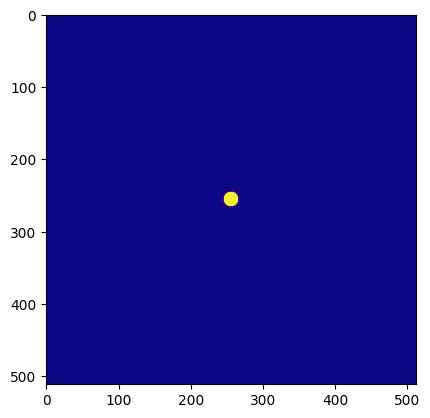

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(fftshift(np.abs(u2)**2), cmap="plasma")